## Digital approach to solving a QUBO: using QAOA and Linear Entanglement Ansatz.

In [1]:
from aquapointer.digital.loaddata import LoadData
from aquapointer.digital.qubo import Qubo
from aquapointer.digital.vqe import VQE
from aquapointer.digital.qubo_utils import get_ising_hamiltonian
from aquapointer.digital.ansatz import QAOA_ansatz
from aquapointer.slicing import crop_slices
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.analog.utils import detuning_scale_utils as dsu

# General imports
import numpy as np
import matplotlib.pyplot as plt

# Pre-defined ansatz circuit, operator class
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit.primitives import BackendSampler
from qiskit import transpile 
from qiskit_aer import AerSimulator

In [2]:
def get_rescaled_register_positions(densities):
    estimated_variance = 50
    estimated_amplitude = 6

    origin = (-20, -20)
    length = 40
    npoints = len(densities[0])
    canvas = DensityCanvas(
        origin=origin,
        length_x=length,
        length_y=length,
        npoints_x=npoints,
        npoints_y=npoints,
    )
    rescaled_positions = []
    for density in densities:    
        canvas.set_density_from_slice(density)
        canvas.set_poisson_disk_lattice(spacing=(2, 10))
        # canvas.set_rectangular_lattice(num_x=8, num_y=8, spacing=4)
        _ = canvas.calculate_pubo_coefficients(
                p = 2, #order of the PUBO, p=2 effectively creates a QUBO
                params = [estimated_amplitude, estimated_variance]
            )
        canvas.force_lattice_size(4)
        canvas.draw(draw_lattice=True)
        rescaled_positions.append(canvas._lattice._coords)

    return rescaled_positions

First we use LoadData to load all the 3D RISM slices of some protein and (scaled) register positions of the corresponding QPU. Then we use Qubo to compute the corresponding QUBO matrices and Ising Hamiltonians.

In [3]:
# LoadData does all the file loading.
ld = LoadData(protein='MUP1')
# Qubo computes all the qubo matrices given the 3d rism 
# files and rescaled positions of registers from LoadData.
q = Qubo(ld.densities, ld.rescaled_register_positions)

Since the density files are zoomed out, we want to focus on particular regions that are interesting. Let's try and find one interesting QUBO for the 1NNC protein.

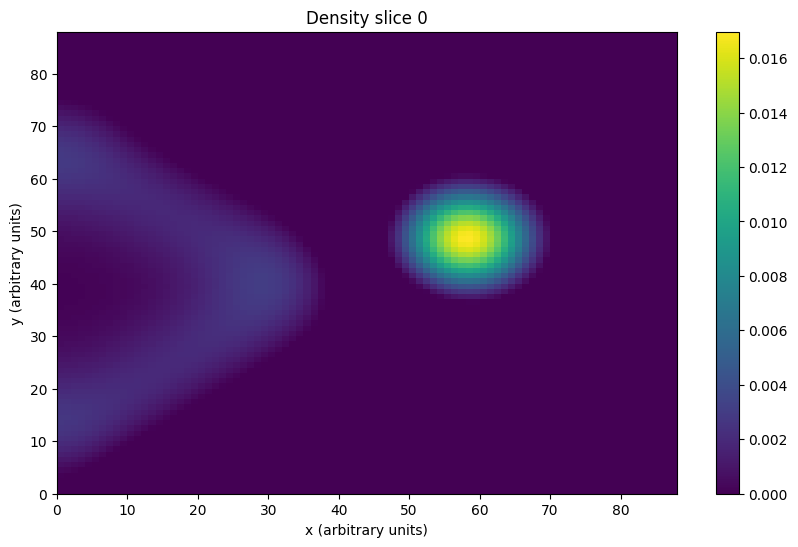

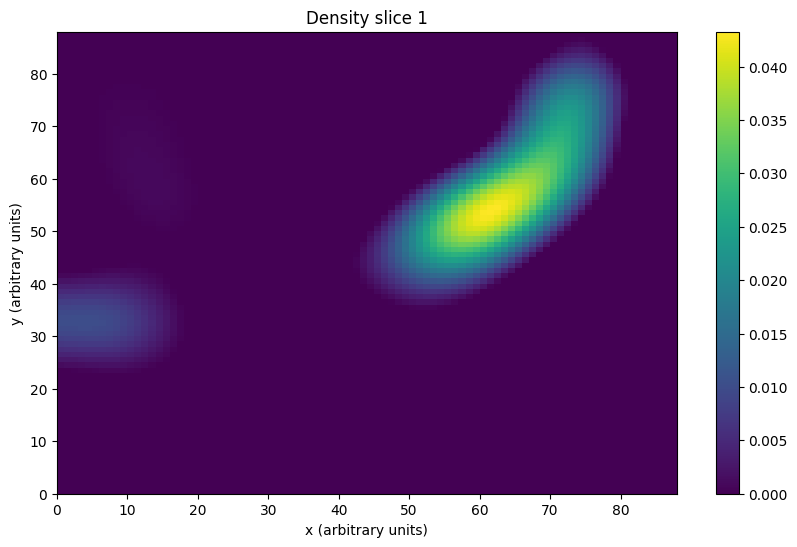

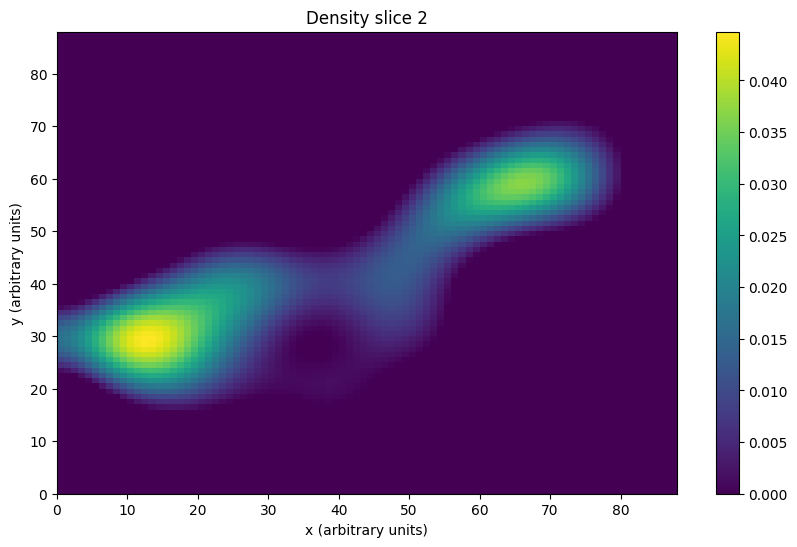

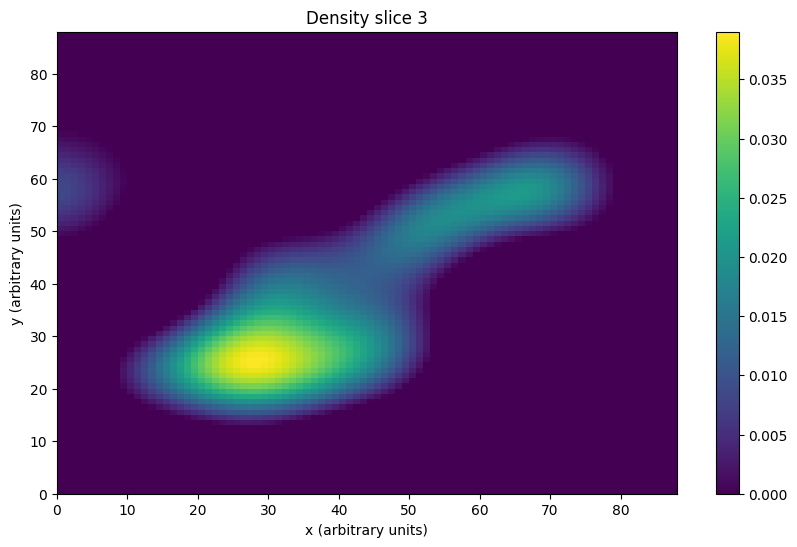

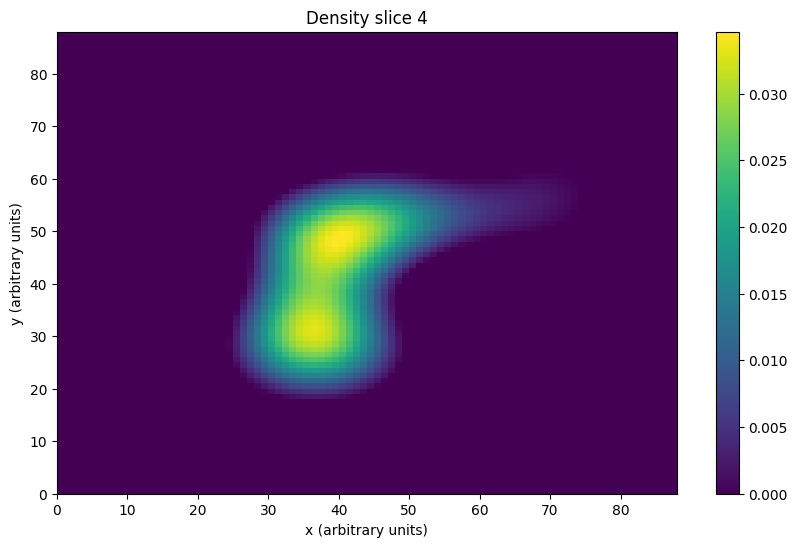

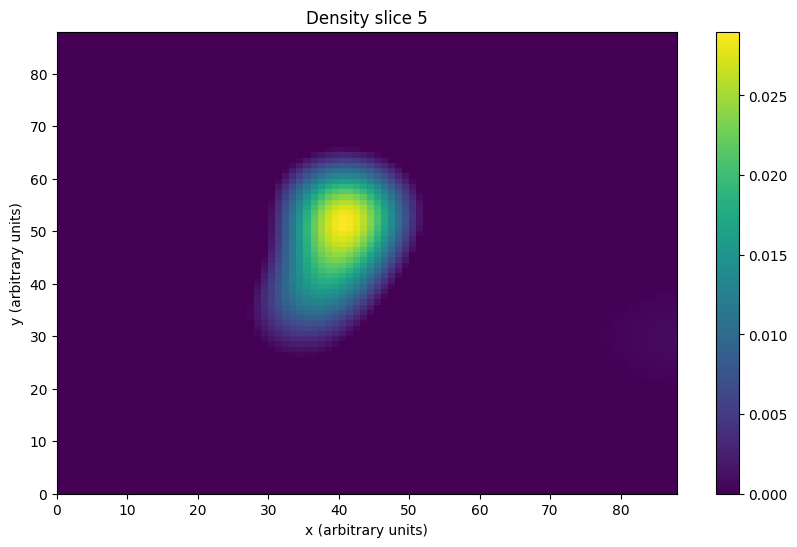

In [4]:
for k, density in enumerate(ld.densities):
    fig, ax = dsu.plot_density(
            density, title=f"Density slice {k}"
        )
plt.show()

In [5]:
# 15.143  19.574  51.153
cropped_points, cropped_densities = crop_slices(ld.plane_points, ld.densities, x_ranges = [(ld.plane_points[2][20, 20, 0], ld.plane_points[2][60, 20, 0])], y_ranges = [(ld.plane_points[2][20, 20, 1], ld.plane_points[3][20, 60, 1])])

In [15]:
# for k, density in enumerate(cropped_densities):
#     fig, ax = dsu.plot_density(
#             density, title=f"Density slice {k}"
#         )
# plt.show()

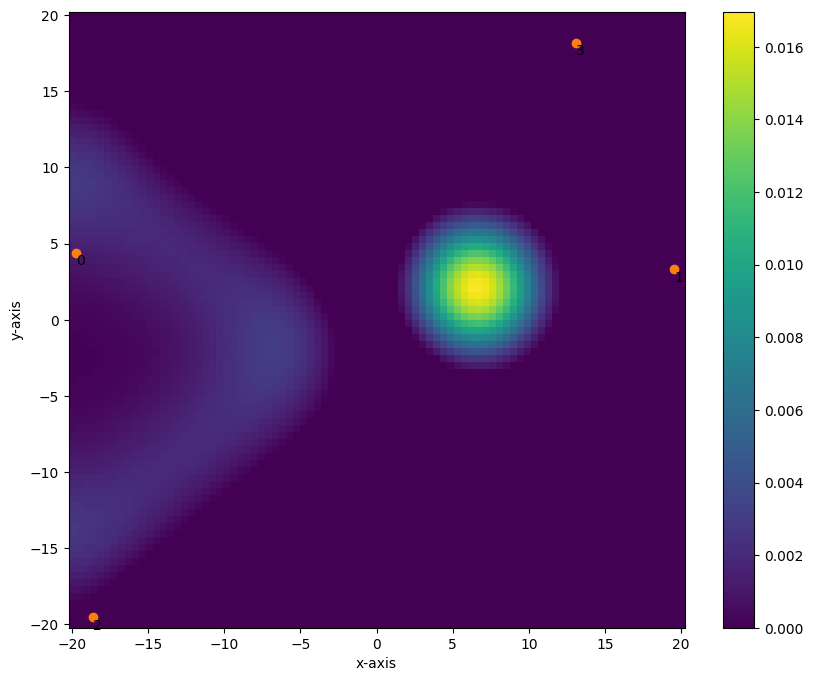

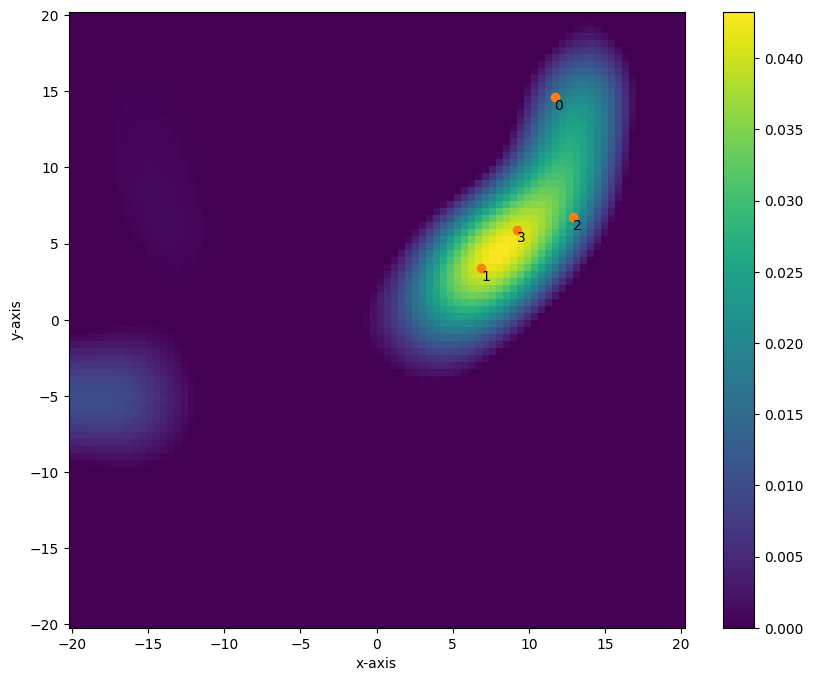

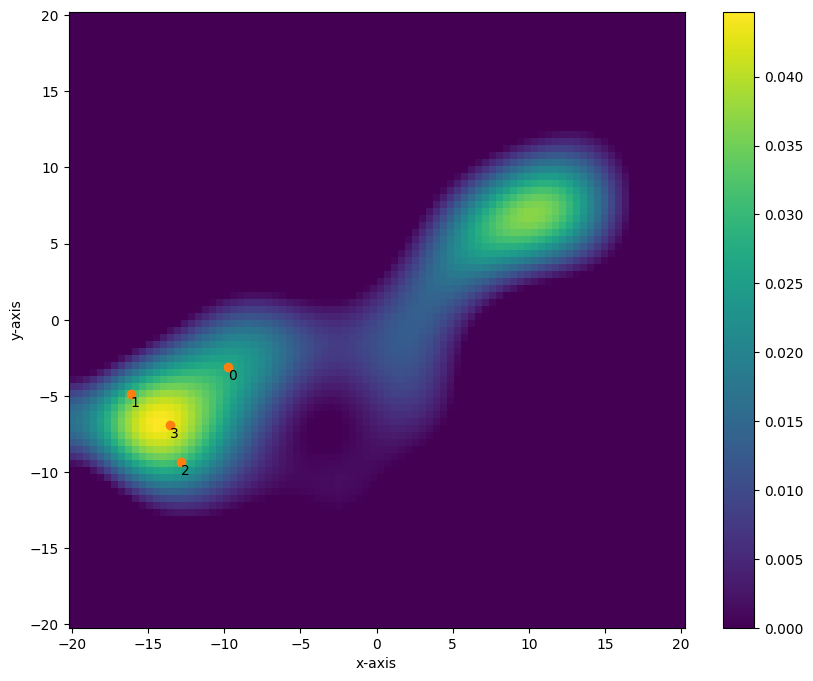

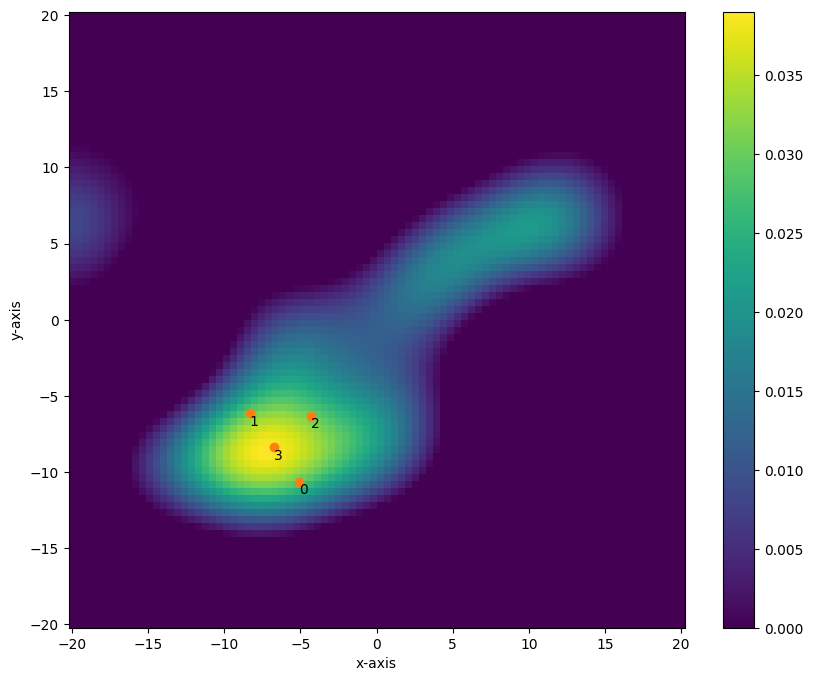

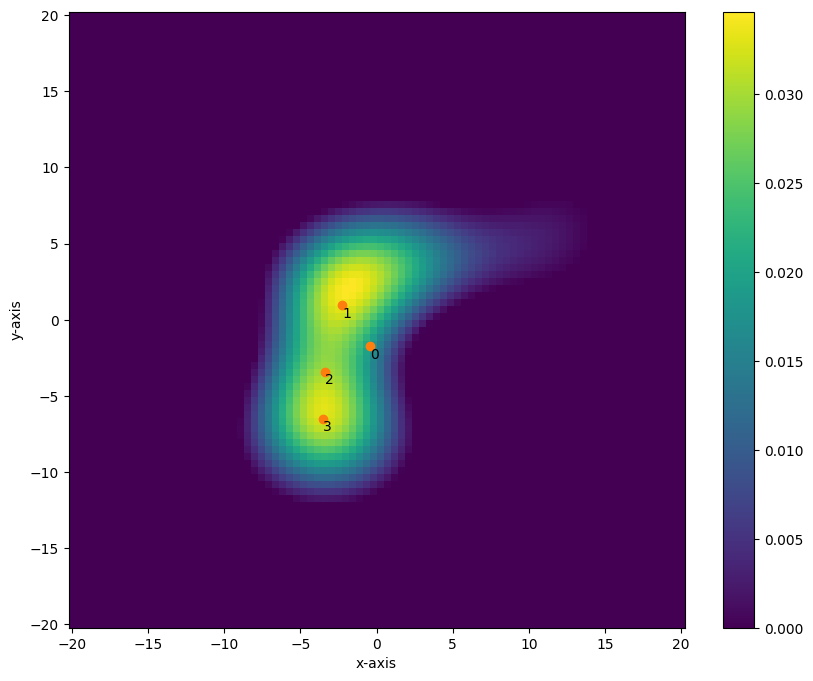

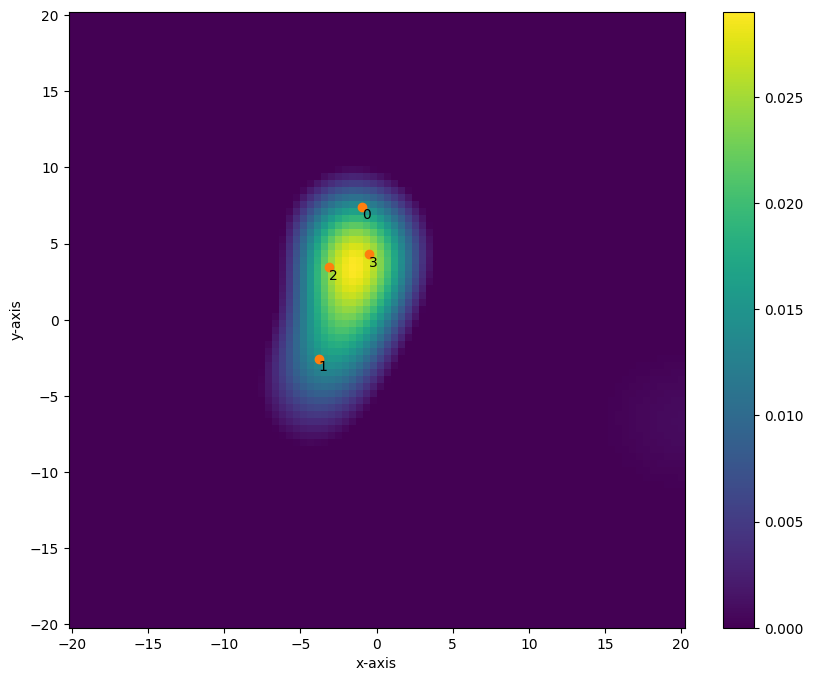

In [7]:
# rescaled_register_positions = get_rescaled_register_positions(cropped_densities)

# q = Qubo(cropped_densities, rescaled_register_positions)

rescaled_register_positions = get_rescaled_register_positions(ld.densities)
q = Qubo(ld.densities, rescaled_register_positions)

We pick one QUBO matrix Ising Hamiltonian from the Qubo object and use that to define the ansatzes.

In [8]:
# Use the first slice as an example to solve.
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

# Print the qubo matrix.
qubo, qubo.shape

(array([[-5.44640805e-06,  1.07930773e-05,  2.33329041e-08,
          2.83264598e-05],
        [ 1.07930773e-05,  1.10745651e-03,  1.06974768e-07,
          1.51992724e-02],
        [ 2.33329041e-08,  1.06974768e-07, -3.90985409e-09,
          4.84735425e-08],
        [ 2.83264598e-05,  1.51992724e-02,  4.84735425e-08,
         -5.95166640e-04]]),
 (4, 4))

Qubo object also has a function that computes the optimal bitstring and corresponding energy using classical brute-force approach.

In [9]:
# classical brute-force solution
solution = q.find_optimum(qubo=qubo)
solution

('0001', -0.0005951666403773826)

For illustration, here is a drawing of the Linear Entanglement ansatz.

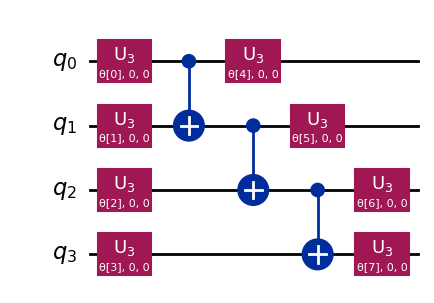

In [10]:
# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

# Drawing of the Linear Entanglement ansatz circuit.
basis_gates=['u1', 'u2', 'u3', 'cx']
ansatz_transpiled = transpile(le_ansatz, AerSimulator(), basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=2)
ansatz_transpiled.draw('mpl', style='iqp')

Now that we have defined the qubo and ansatzes to be used, we use the VQE module to apply the variational approach. VQE accepts a qubo matrix, an ansatz, a sampler and initial parameters.

In [11]:
# EXAMPLE: QAQA

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# QAOA ansatz circuit.
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

alpha = 0.5 # confidence level for CVaR

# Initial parameters for the QAOA ansatz.
beta  = [0.7977]
gamma = [0.0765]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

# Run the minimization.
vqe_qaoa.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_qaoa.history

[['0001', 0.062, -0.0005951666403773826],
 ['0001', 0.0611, -0.0005951666403773826],
 ['0001', 0.0603, -0.0005951666403773826],
 ['0001', 0.0628, -0.0005951666403773826],
 ['0001', 0.0569, -0.0005951666403773826],
 ['0001', 0.0585, -0.0005951666403773826],
 ['0001', 0.0585, -0.0005951666403773826],
 ['0001', 0.0627, -0.0005951666403773826],
 ['0001', 0.0606, -0.0005951666403773826],
 ['0001', 0.0609, -0.0005951666403773826]]

In [12]:
# EXAMPLE: LE
np.random.seed(1)

# Define a backend and sampler.
backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

# Linear Entanglement ansatz circuit.
le_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

alpha = 0.5 # confidence level for CVaR

params_le = np.array([np.random.random()]*le_ansatz.num_parameters)
vqe_le = VQE(qubo=qubo, ansatz=le_ansatz, sampler=sampler, params=params_le, prob_opt_sol=True)

# Now run the minimization procedure.
vqe_le.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_le.history

[['0001', 0.0004, -0.0005951666403773826],
 ['0001', 0.0011, -0.0005951666403773826],
 ['0001', 0.0014, -0.0005951666403773826],
 ['0001', 0.0085, -0.0005951666403773826],
 ['0001', 0.0799, -0.0005951666403773826],
 ['0001', 0.0115, -0.0005951666403773826],
 ['0001', 0.0185, -0.0005951666403773826],
 ['0001', 0.1698, -0.0005951666403773826],
 ['0001', 0.0006, -0.0005951666403773826],
 ['0001', 0.1559, -0.0005951666403773826]]

QAOA with warmstart.

In [13]:
# EXAMPLE: QAQA with warm start
np.random.seed(1)

qaoa_ansatz = QAOA_ansatz(qubo=qubo)

alpha = 0.7
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

vqe_qaoa.run(alpha=alpha, maxiter=10)
vqe_qaoa.history

[['0001', 0.0672, -0.0005951666403773826],
 ['0001', 0.8076, -0.0005951666403773826],
 ['0001', 0.8037, -0.0005951666403773826],
 ['0001', 0.0001, -0.0005951666403773826],
 ['0001', 0.0936, -0.0005951666403773826],
 ['0001', 0.9926, -0.0005951666403773826],
 ['0001', 0.8008, -0.0005951666403773826],
 ['0001', 0.8537, -0.0005951666403773826],
 ['0001', 0.8059, -0.0005951666403773826],
 ['0001', 0.8154, -0.0005951666403773826]]

The QUBO we solved is from a 3D RISM file. If you want to solve an arbitrary QUBO, we can do that as well.

In [14]:
# Define the QUBO matrix that you want to solve. Here we use a random symmetric matrix.

np.random.seed(3)
n = 4  # Size of the matrix
random_matrix = np.random.uniform(-0.5, 0.5, size=(n, n))
Q = (random_matrix + random_matrix.T)/2


# Now, the workflow is the same as above: define your favorite ansatz and minimize.
num_qubits = len(Q)
ham = get_ising_hamiltonian(Q)

# QAOA ansatz circuit.
qaoa_ansatz = QAOAAnsatz(ham, reps=1)

alpha = 0.5 # confidence level for CVaR

# Initial parameters for the QAOA ansatz.
beta  = [0.7977]
gamma = [0.0765]
params = np.array(beta+gamma)
vqe_qaoa = VQE(qubo=Q, ansatz=qaoa_ansatz, sampler=sampler, params=params, prob_opt_sol=True)

# Run the minimization.
vqe_qaoa.run(alpha=alpha, maxiter=10)

# history records the probability of lowest sampled energy at each iteration.
vqe_qaoa.history

[['1010', 0.0564, -1.0769539443330833],
 ['1010', 0.0002, -1.0769539443330833],
 ['1010', 0.1352, -1.0769539443330833],
 ['1010', 0.0648, -1.0769539443330833],
 ['1010', 0.1873, -1.0769539443330833],
 ['1010', 0.0183, -1.0769539443330833],
 ['1010', 0.2323, -1.0769539443330833],
 ['1010', 0.2131, -1.0769539443330833],
 ['1010', 0.1507, -1.0769539443330833],
 ['1010', 0.2318, -1.0769539443330833]]